# Stock Classification




### by Sumer Malhotra (3035347457)

### Importing Libraries

In [35]:
import datetime
import re
import time
import string
import requests
import warnings
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import GetOldTweets3 as got
from langdetect import detect
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Retrieval

### Input for Program - Ticker List

In [36]:
_tickers = pd.read_excel('tickers.xlsx')
_tickers = [(r['Ticker'], r['Name']) for i, r in _tickers.iterrows()]
_tickers

[('0008.HK', 'PCCW'),
 ('0315.HK', 'SmarTone'),
 ('0522.HK', 'ASM Pacific Technology'),
 ('2018.HK', 'AAC Technologies Holdings'),
 ('AAPL', 'Apple Inc'),
 ('MSFT', 'Microsoft'),
 ('FB', 'Facebook Inc'),
 ('INTC', 'Intel Corporation'),
 ('IBM', 'International Business Machines Corporation'),
 ('ORCL', 'Oracle Corporation'),
 ('NVDA', 'NVIDIA Corporation'),
 ('CSCO', 'Cisco Systems Inc'),
 ('MU', 'Micron Technology Inc'),
 ('ADBE', 'Adobe Inc'),
 ('TCEHY', 'Tencent Holdings Limited'),
 ('QCOM', 'QUALCOMM Incorporated'),
 ('XRX', 'Xerox Holdings Corporation'),
 ('NTAP', 'NetApp Inc'),
 ('NOW', 'ServiceNow Inc'),
 ('TXN', 'Texas Instruments Incorporated'),
 ('STX', 'Seagate Technology'),
 ('DELL', 'Dell Technologies Inc'),
 ('CTSH', 'Cognizant Technology Solutions Corporation'),
 ('ACN', 'Accenture PLC'),
 ('GLW', 'Corning Incorporated')]

### Data Retrieval Helper Functions

In [37]:
# Used to load dynamic data on pages where scrolling is required to refresh
def scroll_to_bottom(driver):
    old_position = 0
    new_position = None
    while new_position != old_position:
        # Get old scroll position
        old_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                 " window.pageYOffset : (document.documentElement ||"
                 " document.body.parentNode || document.body);"))
        # Sleep and Scroll
        time.sleep(1)
        driver.execute_script((
                "var scrollingElement = (document.scrollingElement ||"
                " document.body);scrollingElement.scrollTop ="
                " scrollingElement.scrollHeight;"))
        # Get new position
        new_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                 " window.pageYOffset : (document.documentElement ||"
                 " document.body.parentNode || document.body);"))

# Used to pull and parse pricing information from yahoo finance
def getPrices(driver, ticker, start, end):
    print("Getting Prices...")
    base = f"https://in.finance.yahoo.com/quote/{ticker}/history?period1={start}&period2={end}&interval=1d&filter=history&frequency=1d"
    driver.get(base)
    scroll_to_bottom(driver)
    soup = BeautifulSoup(driver.page_source, 'lxml')
    data_table = soup.find('table')
    table_rows = data_table.find_all('tr')
    l = []
    for tr in table_rows:
        td = tr.find_all('td')
        row = [tr.text for tr in td]
        l.append(row)
    data = pd.DataFrame(l, columns=["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"])
    data = data.iloc[1:-1, :]
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[data['Volume'].notnull()]
    return data

# Used to pull and parse income statement from yahoo finance
def getIncomeStatement(driver, ticker):
    print("Getting Income statement...")
    base = f"https://in.finance.yahoo.com/quote/{ticker}/financials?p={ticker}"
    driver.get(base)
    scroll_to_bottom(driver)
    soup = BeautifulSoup(driver.page_source, 'lxml')
    header = soup.find('div', {'class': 'D(tbhg)'})
    data = soup.find('div', {'class': 'D(tbrg)'})
    cols = [i.text for i in header.find_all('span')]
    result = []
    for elem in data.find_all('div', {'class': 'rw-expnded'}):
        smallerOnes = elem.find_all('div', {'class': 'rw-expnded'})
        if len(smallerOnes) == 0:
            row = []
            element = elem.find('div')
            elems = element.find_all('div')
            counter = 0
            isNotBlank = 0
            for j in range(len(elems[1:])):
                if counter != 1:
                    concerned = elems[j+1].select('div span')
                    if str(concerned).find("EPS") != -1:
                        eps_row = []
                        for ct in [1, 3, 4, 5, 6, 7]:
                            eps_row.append(elems[j+ct].text)
                        result.append(eps_row)
                        continue
                    if len(concerned) == 0:
                        row.append('-')
                    else:
                        isNotBlank += 1
                        row.append(concerned[0].text)
                counter += 1
            if isNotBlank > 1:
                result.append(row)
    return pd.DataFrame(columns=cols, data=result)
               
# Used to pull and parse balance sheet from yahoo finance
def getBalanceSheet(driver, ticker):
    print("Getting Balance Sheet...")
    base = f"https://in.finance.yahoo.com/quote/{ticker}/balance-sheet?p={ticker}"
    driver.get(base)
    scroll_to_bottom(driver)
    soup = BeautifulSoup(driver.page_source, 'lxml')
    header = soup.find('div', {'class': 'D(tbhg)'})
    data = soup.find('div', {'class': 'D(tbrg)'})
    cols = [i.text for i in header.find_all('span')]
    result = []
    for elem in data.find_all('div', {'class': 'rw-expnded'}):
        smallerOnes = elem.find_all('div', {'class': 'rw-expnded'})
        if len(smallerOnes) == 0:
            row = []
            element = elem.find('div')
            elems = element.find_all('div')
            counter = 0
            isNotBlank = 0
            for j in elems[1:]:
                if counter != 1:
                    concerned = j.select('div span')
                    if len(concerned) == 0:
                        row.append('-')
                    else:
                        isNotBlank += 1
                        row.append(concerned[0].text)
                counter += 1
            if isNotBlank > 1:
                result.append(row)
        else:
            row = []
            for j in smallerOnes:
                if len(j.find_all('span')) == 1:
                    counter = 0
                    for x in j.select('div')[2:-1]:
                        if counter != 1:
                            row.append(x.text)
                        counter += 1
                    noBlank = 0
                    for i in row:
                        if i == '-':
                            noBlank += 1
                    if noBlank != len(row) - 1:
                        result.append(row)
                    row = []
    return pd.DataFrame(columns=cols, data=result)

# Used to pull and parse cash flow statement from yahoo finance
def getCashFlow(driver, ticker):
    print("Getting Cash Flow...")
    base = f"https://in.finance.yahoo.com/quote/{ticker}/cash-flow?p={ticker}"
    driver.get(base)
    scroll_to_bottom(driver)
    soup = BeautifulSoup(driver.page_source, 'lxml')
    header = soup.find('div', {'class': 'D(tbhg)'})
    data = soup.find('div', {'class': 'D(tbrg)'})
    cols = [i.text for i in header.find_all('span')]
    result = []
    for elem in data.find_all('div', {'class': 'rw-expnded'}):
        smallerOnes = elem.find_all('div', {'class': 'rw-expnded'})
        if len(smallerOnes) == 0:
            row = []
            element = elem.find('div')
            elems = element.find_all('div')
            counter = 0
            isNotBlank = 0
            for j in elems[1:]:
                if counter != 1:
                    concerned = j.select('div span')
                    if len(concerned) == 0:
                        row.append('-')
                    else:
                        isNotBlank += 1
                        row.append(concerned[0].text)
                counter += 1
            if isNotBlank > 1:
                result.append(row)
        else:
            row = []
            for j in smallerOnes:
                if len(j.find_all('span')) == 1:
                    counter = 0
                    for x in j.select('div')[2:-1]:
                        if counter != 1:
                            row.append(x.text)
                        counter += 1
                    noBlank = 0
                    for i in row:
                        if i == '-':
                            noBlank += 1
                    if noBlank != len(row) - 1:
                        result.append(row)
                    row = []
    return pd.DataFrame(columns=cols, data=result)

# To convert date to epoch
def getEpoch(year, month, day):
    epoch = str(datetime.datetime(year, month, day,0,0).timestamp())[:-2]
    return epoch

### Tweet Cleaning Functions

In [38]:
table = str.maketrans('', '', string.punctuation)
stop_words = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

def clean_tweet(tweet):   
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)  
    tokens = tweet.split()
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    _string = ""
    if len(tokens) > 1:
        for t in tokens:
            _string += t + " "
        try:
            if detect(_string) == 'en':
                return _string
        except:
            return None
    return None

def filterTweets(t):
    print("Removing mentions, hashtags, URL links, punctuations, stopwords")
    filtered = {}
    for tweet in t:
        date = tweet.date.strftime("%Y-%m-%d")
        tweet = clean_tweet(tweet.text)
        if tweet is not None:
            filtered[date] = tweet
    return pd.DataFrame(filtered.items(), columns=['Date', 'Tweet'])

### Data pre-preprocessing
Functions to convert raw data to usable data (data which will then need to be preprocessed)

In [39]:
# Changing date to format used by yahoo finance
def resolveDate(date):
    _date = date.strftime("%d/%m/%Y")
    toReturn = ""
    split = _date.split('/')
    for e in split:
        toReturn = toReturn + str(int(e)) + '/'
    return toReturn[:-1]

# Function to return dependent variables - boolean
def getDependents(prices, date):
    start = date + pd.Timedelta(days=2)
    months = 3
    days = months * 30
    end =  start + pd.Timedelta(days=days)
    startFlag = False
    endFlag = False
    while not endFlag:
        try:
            endPrice = float(prices[prices['Date'] == end.strftime("%Y-%m-%d")]['Close'].tolist()[0])
            endFlag = True
        except Exception as e:
            end = end - pd.Timedelta(days=1)
    while not startFlag:
        try:
            startPrice = float(prices[prices['Date'] == start.strftime("%Y-%m-%d")]['Close'].tolist()[0])
            startFlag = True
        except Exception as e:
            start = start + pd.Timedelta(days=1)
    if startPrice < endPrice:
        flag = 1
    else:
        flag = 0
    return flag

# Function to get return on prices for a certain period (1/3/6/12 month(s)) from date-period to date
def getReturn(prices, period, date):
    end = date + pd.Timedelta(days=1)
    months = int(period.replace('m', ''))
    days = months * 30
    start =  end - pd.Timedelta(days=days)
    daysToRemove = start.day - 1
    startFlag = False
    endFlag = False
    start = start - pd.Timedelta(days=daysToRemove)
    while not endFlag:
        try:
            endPrice = float(prices[prices['Date'] == end.strftime("%Y-%m-%d")]['Close'].tolist()[0])
            endFlag = True
        except Exception as e:
            end = end - pd.Timedelta(days=1)
    while not startFlag:
        try:
            startPrice = float(prices[prices['Date'] == start.strftime("%Y-%m-%d")]['Close'].tolist()[0])
            startFlag = True
        except Exception as e:
            start = start + pd.Timedelta(days=1)
    return (endPrice - startPrice) / startPrice

# Function to query tweets
def getTweets(ticker, end):
    print("Getting Tweets...")
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(f"{ticker[0]} OR {ticker[1]}")\
                                               .setUntil(end)\
                                               .setMaxTweets(100)
    return got.manager.TweetManager.getTweets(tweetCriteria)

# Function to generate datepoints
def generatePoints(statement):
    points = []
    for l in statement.columns.tolist():
        try:
            date = datetime.datetime.strptime(l, "%d/%m/%Y")
            points.append(date.strftime("%Y-%m-%d"))
        except Exception as e:
            continue
    return points

# Function to generate ticker sentiment using an average score of NLTK Vader and TextBlob
def generateSentiment(ticker, years):
    sentiments = {}
    for y in years:
        tweets = filterTweets(getTweets(ticker, y))
        sentiments[y] = np.mean([(TextBlob(r['Tweet']).sentiment.polarity +
                                  sid.polarity_scores(r['Tweet'])['compound'])/2 for i, r in tweets.iterrows()])
    return pd.DataFrame(sentiments.items(), columns=['Date', 'Sentiment'])
        
# Function which uses all other function to convert raw data to usable data
def generateData(data, ticker):
    prices = data['Prices']
    income_statement = data['Income']
    balance_sheet = data['Balance']
    cash_flow = data['Cash']
    prices['Date'] = pd.to_datetime(prices['Date'])
    sentiments = generateSentiment(ticker, generatePoints(cash_flow))
    print("Creating datapoints...")
    sentiments['Date'] = pd.to_datetime(sentiments['Date'])
    pes = []
    pbs = []
    des = []
    opms = []
    evebitdas = []
    roes = []
    interestcoverages = []
    currentratios = []
    assetturnovers = []
    roics = []
    roas = []
    profitmargins = []
    ret1s = []
    ret3s = []
    ret6s = []
    ret12s = []
    y_booleans = []
    for i, r in sentiments.iterrows():
        date = r['Date']
        year = date.year
        filtered = prices[prices['Date'].dt.year == year]
        ret1, ret3, ret6, ret12 = [getReturn(prices, period, date) for period in ['1m', '3m', '6m', '12m']]
        y_boolean = getDependents(prices, date)
        price = np.mean(pd.to_numeric(filtered['Close']))
        eps = income_statement[resolveDate(date)][income_statement['Breakdown'] == 'Diluted EPS'].tolist()[0]
        if eps == '-':
            eps = income_statement[resolveDate(date - datetime.timedelta(days=365))][income_statement['Breakdown'] == 'Diluted EPS'].tolist()[0]
        eps = float(eps)
        pe_ratio = price/eps
        total_assets = balance_sheet[resolveDate(date)][balance_sheet['Breakdown'] == 'Total assets'].tolist()[0]
        total_assets = int(total_assets.replace(',', ''))
        total_liabilities = int(balance_sheet[resolveDate(date)][balance_sheet['Breakdown'] == 'Total liabilities'].\
                            tolist()[0].replace(',', ''))
        book_value = total_assets - total_liabilities
        outstanding_shares = int((balance_sheet[resolveDate(date)][balance_sheet['Breakdown'] ==\
                            "Total stockholders' equity"].tolist()[0]).replace(',', ''))
        book_value_pershare = book_value / outstanding_shares
        pb_ratio = price / book_value_pershare
        de_ratio = total_liabilities / outstanding_shares
        op_earnings = int((income_statement[resolveDate(date)][income_statement['Breakdown'] ==\
                            "Operating income or loss"].tolist()[0]).replace(',', ''))
        total_rev = int((income_statement[resolveDate(date)][income_statement['Breakdown'] ==\
                            "Total revenue"].tolist()[0]).replace(',', ''))
        opm = op_earnings / total_rev
        market_cap = outstanding_shares * price
        cash = int((balance_sheet[resolveDate(date)][balance_sheet['Breakdown'] ==\
                            "Cash and cash equivalents"].tolist()[0]).replace(',', ''))
        ev = market_cap + total_liabilities - cash
        ebitda = int((income_statement[resolveDate(date)][income_statement['Breakdown'] ==\
                            "EBITDA"].tolist()[0]).replace(',', ''))
        ev_ebitda = ev / ebitda
        net_income = int((income_statement[resolveDate(date)][income_statement['Breakdown'] ==\
                            "Net income"].tolist()[0]).replace(',', ''))
        roe = net_income / outstanding_shares
        interest_expense = int((income_statement[resolveDate(date)][income_statement['Breakdown'] ==\
                            "Interest expense"].tolist()[0]).replace(',', ''))
        interest_coverage_ratio = op_earnings / interest_expense
        current_assets = int((balance_sheet[resolveDate(date)][balance_sheet['Breakdown'] ==\
                            "Total current assets"].tolist()[0]).replace(',', ''))
        current_liabilties = int((balance_sheet[resolveDate(date)][balance_sheet['Breakdown'] ==\
                            "Total current liabilities"].tolist()[0]).replace(',', ''))
        current_ratio = current_assets / current_liabilties
        asset_turnover = total_rev / total_assets
        income_tax = int((income_statement[resolveDate(date)][income_statement['Breakdown'] ==\
                            "Income tax expense"].tolist()[0]).replace(',', ''))
        roic = (op_earnings - income_tax) / (total_liabilities + outstanding_shares)
        roa = net_income / total_assets
        gross_profit = int((income_statement[resolveDate(date)][income_statement['Breakdown'] ==\
                            "Gross profit"].tolist()[0]).replace(',', ''))
        profit_margin = gross_profit / total_rev
        pes.append(pe_ratio)
        pbs.append(pb_ratio)
        des.append(de_ratio)
        opms.append(opm)
        evebitdas.append(ev_ebitda)
        roes.append(roe)
        interestcoverages.append(interest_coverage_ratio)
        currentratios.append(current_ratio)
        assetturnovers.append(asset_turnover)
        roics.append(roic)
        roas.append(roa)
        profitmargins.append(profit_margin)
        ret1s.append(ret1)
        ret3s.append(ret3)
        ret6s.append(ret6)
        ret12s.append(ret12)
        y_booleans.append(y_boolean)
    rest = pd.DataFrame({
        "Date": sentiments['Date'].tolist(),
        "Ticker": [ticker[0] for i in range(sentiments.shape[0])],
        "P/E": pes,
        "P/B": pbs,
        "D/E": des,
        "OPM": opms,
        "EV/EBITDA": evebitdas,
        "ROE": roes,
        "Interest Coverage Ratio": interestcoverages,
        "Current Ratio": currentratios,
        "Asset Turnover": assetturnovers,
        "ROIC": roics,
        "ROA": roas,
        "Profit Margin Ratio": profitmargins,
        "1m Return": ret1s,
        "3m Return": ret3s,
        "6m Return": ret6s,
        "12m Return": ret12s,
        "Good/Bad": y_booleans
    })
    full = pd.merge(sentiments, rest, on='Date')
    return full

## Pulling results

#### Date Function

Timeframe: 2015-01-01 : 2020-04-21

In [40]:
startdate = '2015-01-01'
today = str(startdate)
s_year = today[:4]
s_month = today[5:7]
s_day = today[8:]
enddate = '2020-04-21'
if enddate == '0':
    today = str(datetime.date.today())
    e_year = today[:4]
    e_month = today[5:7]
    e_day = today[8:]
else:
    today = str(enddate)
    e_year = today[:4]
    e_month = today[5:7]
    e_day = today[8:]
start = getEpoch(int(s_year), int(s_month), int(s_day))
end = getEpoch(int(e_year), int(e_month), int(e_day))

### Dataset creation and saving
#### Example shown with 1 stock from _tickers

In [41]:
%%time

results = {}
options = ChromeOptions()
options.headless = True
driver = webdriver.Chrome(options=options)
df = pd.DataFrame()
for ticker in _tickers[:1]:
    print(f"Scraping information for {ticker[1]}...")
    results[ticker[0]] =  {
                           "Prices": getPrices(driver, ticker[0], start, end),
                           "Income": getIncomeStatement(driver, ticker[0]),
                           "Balance": getBalanceSheet(driver, ticker[0]),
                           "Cash": getCashFlow(driver, ticker[0])
                          }
    df = df.append(generateData(results[ticker[0]], ticker), ignore_index=True)
    print('Done...\n')
driver.quit()
# df.to_excel("./Data/output.xlsx", index=False) 

Scraping information for PCCW...
Getting Prices...
Getting Income statement...
Getting Balance Sheet...
Getting Cash Flow...
Getting Tweets...
Removing mentions, hashtags, URL links, punctuations, stopwords
Getting Tweets...
Removing mentions, hashtags, URL links, punctuations, stopwords
Getting Tweets...
Removing mentions, hashtags, URL links, punctuations, stopwords
Getting Tweets...
Removing mentions, hashtags, URL links, punctuations, stopwords
Creating datapoints...
Done...

CPU times: user 5.69 s, sys: 207 ms, total: 5.9 s
Wall time: 1min 36s


In [42]:
results['0008.HK']['Prices']

,Date,Open,High,Low,Close,Adj Close,Volume
1,2020-04-20,4.710,4.710,4.640,4.690,4.690,"43,15,562"
2,2020-04-17,4.670,4.700,4.620,4.700,4.700,"1,08,41,216"
3,2020-04-16,4.600,4.640,4.560,4.640,4.640,"1,08,42,189"
4,2020-04-15,4.640,4.670,4.570,4.580,4.580,"90,70,276"
5,2020-04-14,4.540,4.630,4.520,4.620,4.620,"1,42,02,231"
...,...,...,...,...,...,...,...
1313,2015-01-08,5.230,5.320,5.070,5.100,3.823,"1,09,57,830"
1314,2015-01-07,5.270,5.280,5.150,5.150,3.860,"85,05,997"
1315,2015-01-06,5.260,5.270,5.180,5.210,3.905,"47,26,927"
1316,2015-01-05,5.260,5.280,5.200,5.270,3.950,"49,19,118"


In [43]:
results['0008.HK']['Income']

,Breakdown,ttm,30/12/2019,30/12/2018,30/12/2017,30/12/2016
0,Total revenue,"3,75,21,000","3,75,21,000","3,88,50,000","3,70,50,000","3,83,84,000"
1,Cost of revenue,"1,89,07,000","1,89,07,000","2,06,42,000","1,68,57,000","1,77,43,000"
2,Gross profit,"1,86,14,000","1,86,14,000","1,82,08,000","2,01,93,000","2,06,41,000"
3,Selling general and administrative,"51,37,000","51,37,000","1,29,70,000","1,43,22,000","1,51,14,000"
4,Total operating expenses,"1,31,61,000","1,31,61,000","1,29,70,000","1,43,22,000","1,51,14,000"
5,Operating income or loss,"54,53,000","54,53,000","52,38,000","58,71,000","55,27,000"
6,Interest expense,"19,40,000","19,40,000","18,23,000","14,69,000","12,85,000"
7,Income before tax,"38,11,000","38,11,000","41,84,000","57,34,000","42,27,000"
8,Income tax expense,"9,41,000","9,41,000","11,34,000","11,34,000","3,95,000"
9,Income from continuing operations,"28,70,000","28,70,000","30,50,000","46,00,000","38,32,000"


In [44]:
results['0008.HK']['Balance']

,Breakdown,30/12/2019,30/12/2018,30/12/2017,30/12/2016
0,Cash and cash equivalents,"53,36,000","67,57,000","1,16,38,000","47,51,000"
1,Other Short Term Investments,"4,86,000","6,04,000","17,08,000","4,53,000"
2,Total cash,"58,22,000","73,61,000","1,33,46,000","52,04,000"
3,Net receivables,"46,16,000","47,99,000","36,64,000","37,78,000"
4,Inventory,"26,47,000","20,50,000","9,11,000","9,43,000"
5,Other current assets,"24,89,000","5,07,000","5,08,000","5,10,000"
6,Total current assets,"2,08,68,000","2,14,73,000","2,82,40,000","2,05,14,000"
7,"Gross property, plant and equipment","6,85,00,000","6,42,01,000","5,68,23,000","5,35,99,000"
8,Accumulated depreciation,"-3,65,82,000","-3,57,41,000","-3,47,38,000","-3,34,76,000"
9,"Net property, plant and equipment","3,19,18,000","2,84,60,000","2,20,85,000","2,01,23,000"


In [45]:
results['0008.HK']['Cash']

,Breakdown,ttm,30/12/2019,30/12/2018,30/12/2017,30/12/2016
0,Net income,"6,81,000","6,81,000","8,97,000","22,46,000","20,51,000"
1,Depreciation & amortisation,"56,86,000","56,86,000","55,24,000","67,28,000","67,02,000"
2,Stock-based compensation,"-41,000","-41,000","40,000","48,000","74,000"
3,Change in working capital,"-13,23,000","-13,23,000","-53,52,000","-4,12,000","-21,00,000"
4,Inventory,"-1,39,000","-1,39,000","-29,37,000","-1,64,000","-1,58,000"
5,Other working capital,"17,11,000","17,11,000","-8,71,000","24,31,000","17,94,000"
6,Other non-cash items,"30,18,000","30,18,000","32,32,000","13,92,000","13,77,000"
7,Net cash provided by operating activities,"1,11,33,000","1,11,33,000","65,45,000","1,18,63,000","99,53,000"
8,"Investments in property, plant and equipment","-94,22,000","-94,22,000","-74,16,000","-94,32,000","-81,59,000"
9,"Acquisitions, net","-6,78,000","-6,78,000","-1,03,000","-21,000","-2,42,000"


In [46]:
df

,Date,Sentiment,Ticker,P/E,P/B,D/E,OPM,EV/EBITDA,ROE,Interest Coverage Ratio,Current Ratio,Asset Turnover,ROIC,ROA,Profit Margin Ratio,1m Return,3m Return,6m Return,12m Return,Good/Bad
0,2019-12-30,0.310026,0008.HK,38.284214,3.971913,5.208071,0.145332,12.850417,0.043828,2.810825,1.281267,0.379402,0.046775,0.006886,0.496096,-0.014957,0.047727,0.022173,0.019912,0
1,2018-12-30,0.218247,0008.HK,37.530488,3.926261,4.364902,0.134826,12.561880,0.052471,2.873286,1.471560,0.412302,0.044748,0.009520,0.468674,-0.002212,-0.004415,0.036782,-0.008791,1
2,2017-12-30,0.197364,0008.HK,15.417702,3.842227,3.444912,0.158462,10.495720,0.112632,3.996596,1.906176,0.403156,0.053443,0.024440,0.545020,-0.008734,0.060748,0.034169,0.060748,0
3,2016-12-30,0.048080,0008.HK,18.172590,3.993419,5.388991,0.143992,9.748138,0.170547,4.301167,1.456546,0.482308,0.066793,0.025772,0.537750,-0.078947,-0.135802,-0.204545,-0.051919,1


## Machine Learning 

### Independent Variables

1. Asset Sentiment
- Price-to-Earnings ratio (PE)
- Price-to-Book (PB) ratio
- Net Debt to Equity Ratio
- Operating profit Margin (OPM)
- EV/EBIDTA
- Return on Equity (ROE)
- Interest Coverage ratio
- Current ratio
- Asset Turnover
- Return on Invested Capital (ROIC)
- Return on Asset (ROA)
- Profit Margin
- Past 1m returns
- Past 3m returns
- Past 6m returns 
- Past 1y returns


### Dependent Variable

- Stock classification (1 or 0)

## Dataset Description

The dataset is built up using data from 25 technology stocks, including stocks from HKEX and NASDAQ. For each stock, pricing information, income statement, balance sheet and cash flow statement is scraped from Yahoo Finance. We will call this data the "raw" data. The raw data has a 5.5 year timespan and is capable of generating 4 datapoints for this 5.5 year timespan, 1 point for each 1.25 years. For example, raw data from 2016-01-01 : 2017-03-31 will generate one datapoint, where the independent variables are generated using the first 1 year of data (2016-01-01 : 2017-01-01) and the dependent variable is generated using the last 3 months of data (2017-01-01 : 2017-03-31). i.e. - we use a one year time frame as reference to predict stock movement in the next 3 months. Each datapoint consists of the features mentioned above, or you could simply look at the final df outputted above. The sentiment score for the data is built using filtered querying by date, where 100 tweets are scraped, filtered and cleaned before applying the TextBlob and NLTK Vader libraries to quantify sentiment.

### Final dataset

In [48]:
df = pd.read_excel('./Data/output.xlsx')
df = df.set_index(['Date', 'Ticker'])
df.head(15)

,,Sentiment,P/E,P/B,D/E,OPM,EV/EBITDA,ROE,Interest Coverage Ratio,Current Ratio,Asset Turnover,ROIC,ROA,Profit Margin Ratio,1m Return,3m Return,6m Return,12m Return,Good/Bad
Date,Ticker,,,,,,,,,,,,,,,,,,
2019-12-30,0008.HK,0.305298,38.284214,3.971913,5.208071,0.145332,12.850417,0.043828,2.810825,1.281267,0.379402,0.046775,0.006886,0.496096,-0.014957,0.047727,0.022173,0.019912,0
2018-12-30,0008.HK,0.241099,37.530488,3.926261,4.364902,0.134826,12.561880,0.052471,2.873286,1.471560,0.412302,0.044748,0.009520,0.468674,-0.002212,-0.004415,0.036782,-0.008791,1
2017-12-30,0008.HK,0.197364,15.417702,3.842227,3.444912,0.158462,10.495720,0.112632,3.996596,1.906176,0.403156,0.053443,0.024440,0.545020,-0.008734,0.060748,0.034169,0.060748,0
2016-12-30,0008.HK,0.048080,18.172590,3.993419,5.388991,0.143992,9.748138,0.170547,4.301167,1.456546,0.482308,0.066793,0.025772,0.537750,-0.078947,-0.135802,-0.204545,-0.051919,1
2019-06-29,0315.HK,0.188043,13.787214,7.553861,0.950416,0.097628,21.635906,0.125020,9.672369,1.427957,0.851461,0.064853,0.063973,0.512830,-0.088235,-0.133877,-0.128806,-0.075776,0
2018-06-29,0315.HK,0.124743,16.078936,8.783669,1.080707,0.084595,21.193470,0.128200,9.517188,1.165380,0.997042,0.066614,0.061413,0.475844,-0.016990,-0.024096,-0.133690,-0.202756,1
2017-06-29,0315.HK,0.167513,16.238736,9.979522,1.119239,0.106390,21.779973,0.146314,9.657862,1.048576,0.891548,0.077022,0.068753,0.597955,-0.041276,0.015905,-0.034026,-0.279267,0
2016-06-29,0315.HK,0.153799,16.501916,12.242946,1.399003,0.060076,21.621224,0.184664,11.284252,1.580878,1.764453,0.089586,0.076627,0.302950,0.084906,0.063174,0.195841,0.020710,0
2019-12-30,0522.HK,0.112866,16.638533,90.487347,0.792367,0.079444,530.019243,0.053254,6.992192,3.019004,0.761938,0.043587,0.029706,0.347784,0.061886,0.107582,0.271017,0.434638,0


#### Features

In [49]:
feature_names = df.columns.tolist()[:-1]
print(feature_names)

['Sentiment', 'P/E', 'P/B', 'D/E', 'OPM', 'EV/EBITDA', 'ROE', 'Interest Coverage Ratio', 'Current Ratio', 'Asset Turnover', 'ROIC', 'ROA', 'Profit Margin Ratio', '1m Return', '3m Return', '6m Return', '12m Return']


#### Splitting into train and test set

In [50]:
np.random.seed(30)
df_train, df_test = train_test_split(df, test_size=0.2)
X_train = df_train.iloc[:, 0:-1]
ybool_train = df_train.iloc[:, -1]
X_test = df_test.iloc[:, 0:-1]
ybool_test = df_test.iloc[:, -1]
index = X_test.index

#### Data normalization

In [51]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

#### Gini Decision Tree 

In [52]:
dt1 = DecisionTreeClassifier(criterion='gini')
dt1.fit(X_train, ybool_train)

print('The Acc on training set:', accuracy_score(ybool_train,dt1.predict(X_train)))
print('The Acc on testing set:', accuracy_score(ybool_test,dt1.predict(X_test)))

The Acc on training set: 1.0
The Acc on testing set: 0.5


#### Entropy Decision Tree

In [53]:
dt2 = DecisionTreeClassifier(criterion='entropy')
dt2.fit(X_train, ybool_train)

print('The Acc on training set:', accuracy_score(ybool_train,dt1.predict(X_train)))
print('The Acc on testing set:', accuracy_score(ybool_test,dt1.predict(X_test)))

The Acc on training set: 1.0
The Acc on testing set: 0.5


#### Visualizing trees

In [54]:
dot_graph1 = export_graphviz(
        dt1,
        out_file=None, 
        feature_names=feature_names,
        rounded=True,
        filled=True
    )
dot_graph2 = export_graphviz(
        dt2,
        out_file=None, 
        feature_names=feature_names,
        rounded=True,
        filled=True
    )
tree_graph1 = graphviz.Source(dot_graph1)
tree_graph2 = graphviz.Source(dot_graph2)

#### Un-comment to view fit trees

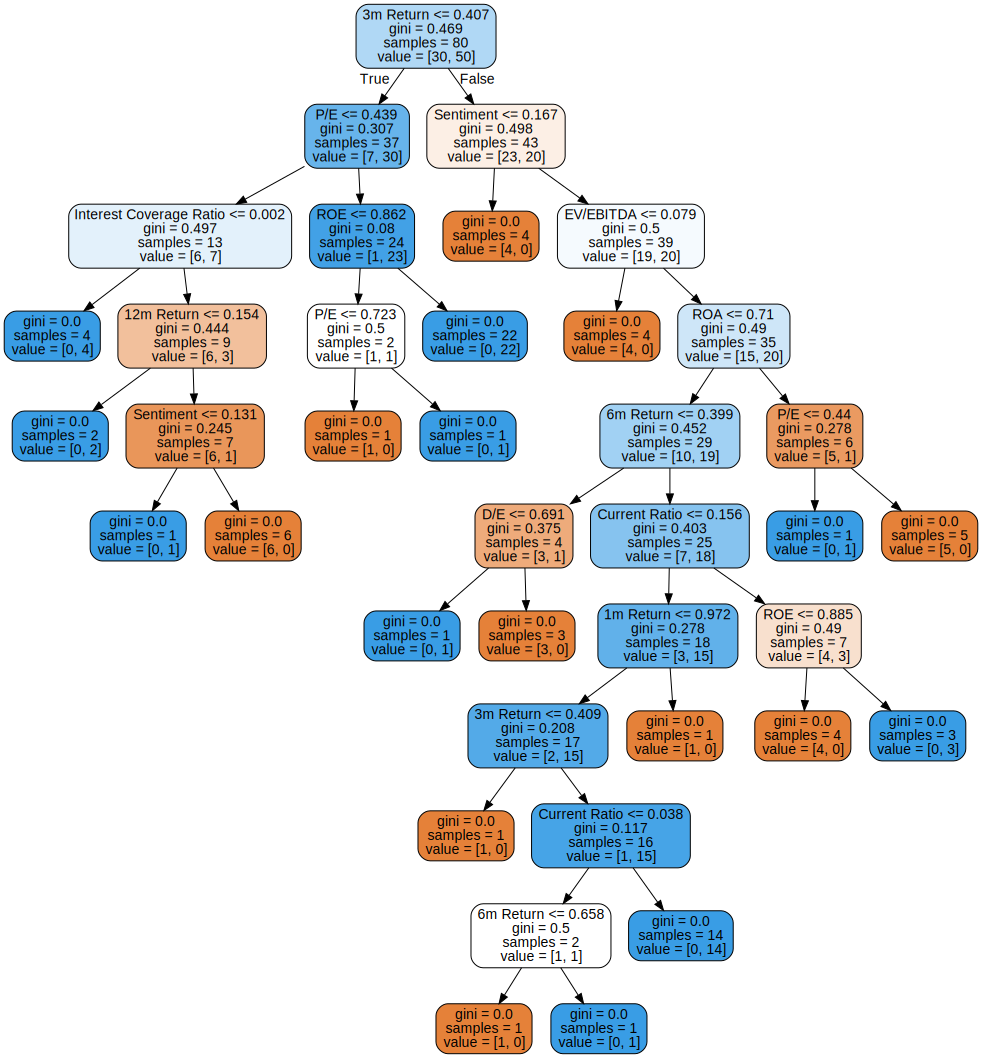

In [55]:
tree_graph1

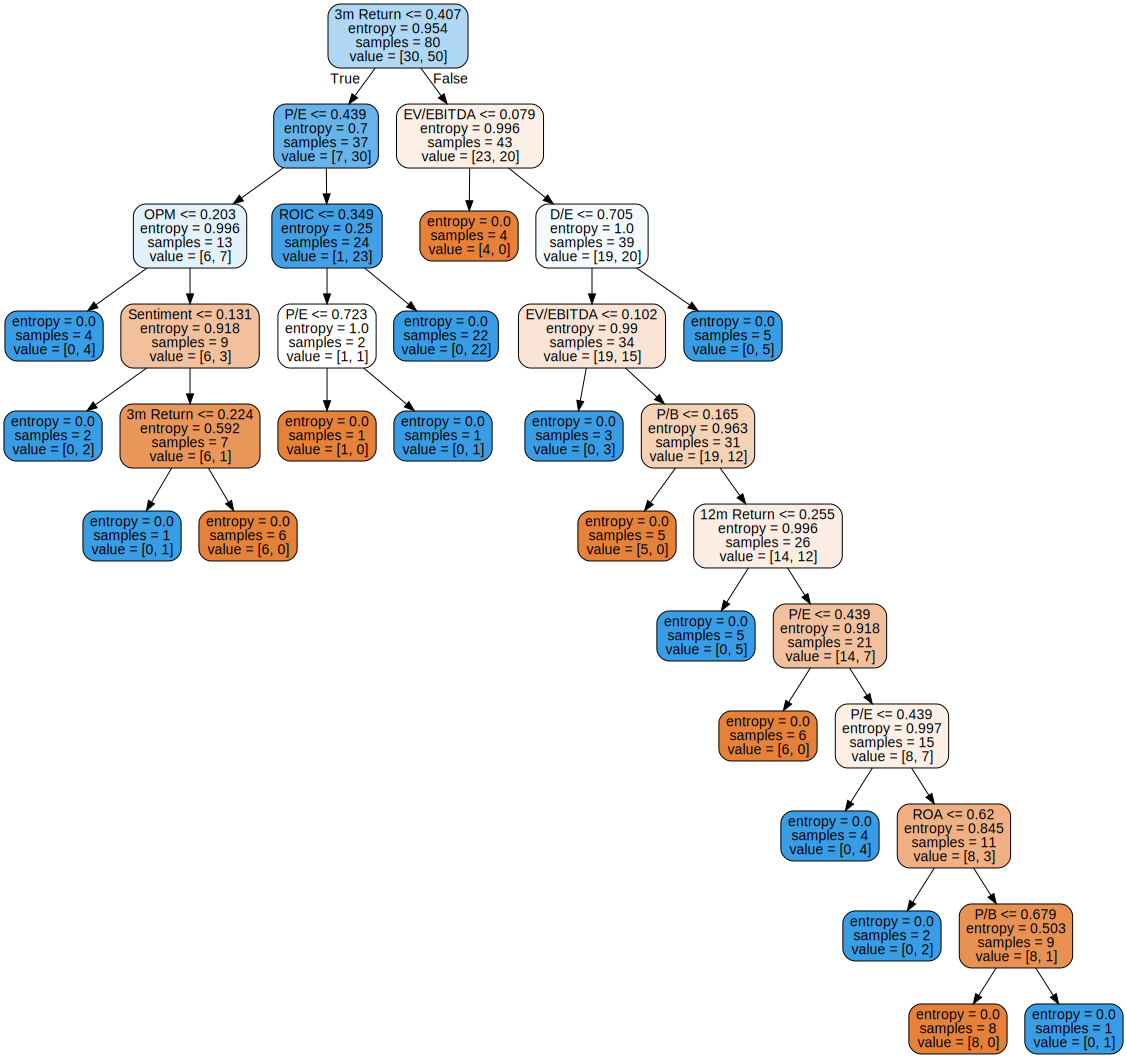

In [57]:
tree_graph2

#### Random Forest

In [58]:
RF_clf = RandomForestClassifier()
RF_clf.fit(X_train, ybool_train)

print('The Acc on training set:', accuracy_score(ybool_train,RF_clf.predict(X_train)))
print('The Acc on testing set:', accuracy_score(ybool_test,RF_clf.predict(X_test)))

The Acc on training set: 1.0
The Acc on testing set: 0.7


#### Linear kernel based Support Vector Classifier

In [59]:
lin_clf = SVC(kernel='linear')
lin_clf.fit(X_train, ybool_train)

print('The Acc on training set:', accuracy_score(ybool_train, lin_clf.predict(X_train)))
print('The Acc on testing set:', accuracy_score(ybool_test, lin_clf.predict(X_test)))

The Acc on training set: 0.675
The Acc on testing set: 0.5


#### RBF kernel based Support Vector Classifier

In [60]:
rbf_clf = SVC(kernel='rbf', gamma='scale')
rbf_clf.fit(X_train, ybool_train)

print('The Acc on training set:', accuracy_score(ybool_train, rbf_clf.predict(X_train)))
print('The Acc on testing set:', accuracy_score(ybool_test, rbf_clf.predict(X_test)))

The Acc on training set: 0.6625
The Acc on testing set: 0.6


---

According to the above results, Random Forest is the best ML algorithm and all post-hoc interpretability will be done with respect to this model. 

---

## Analytics

### Classification Report

In [61]:
print(classification_report(ybool_test, RF_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.68      1.00      0.81        13

    accuracy                           0.70        20
   macro avg       0.84      0.57      0.53        20
weighted avg       0.79      0.70      0.62        20



### Confusion Matrix

[[ 1  6]
 [ 0 13]]


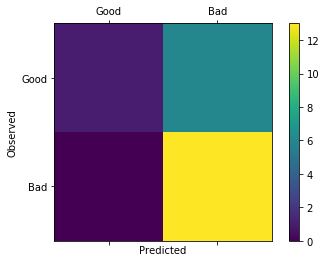

In [62]:
labels = ['Good', 'Bad']
cm = confusion_matrix(ybool_test, RF_clf.predict(X_test))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.show()